<figure>
<img src="https://raw.githubusercontent.com/AprendizajeProfundo/Diplomado-Avanzado/main/Programación/Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Taller de Tensorflow en clasificación de imagenes</center></span>

## <span style="color:blue">Profesores</span>

- Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
- Campo Elías Pardo, PhD, cepardot@unal.edu.co
- Daniel  Montenegro, Msc, dextronomo@gmail.com 
- Oleg Jarma, ojarmam@unal.edu.co

##   <span style="color:blue">Asesora Medios y Marketing digital</span>

- Maria del Pilar Montenegro, pmontenegro88@gmail.com 

Basado en [estos](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control) [tutoriales](https://www.tensorflow.org/tutorials/images/classification#download_and_explore_the_dataset)

Se verá cómo desarrollar un clasificador de imagenes usando tensorflow. Se descargará un dataset, se hará una carga de los datos directamente del disco y se desarrollará un entubamiento de datos a un modelo convolucional.

## Paquetes esenciales

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Descarga y exploración de la base de datos

En este caso usaremos una base de datos de fotos de flores. Este dataset tiene 5 subclases. 

Vamos a obtener la URL de las APIs de google y descargaremos usando Tensorflow

In [9]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, 
                                   cache_dir='/mnt/storage', cache_subdir='Datasets', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

/mnt/storage/Datasets/flower_photos


Obtenemos entonces la cantidad de la imagenes

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Veamos unas rosas

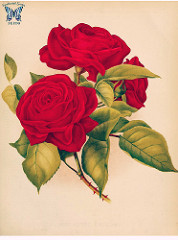

In [11]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

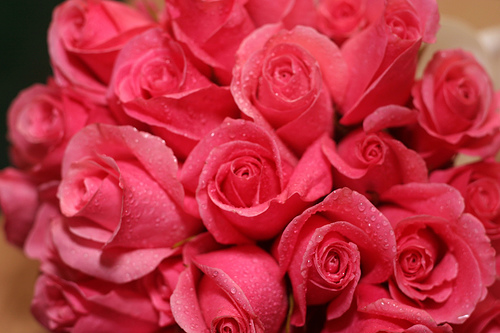

In [12]:
PIL.Image.open(str(roses[1]))

¿Qué tal unos Tulipanes?

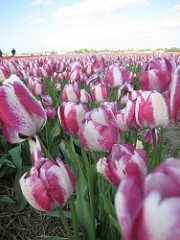

In [13]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

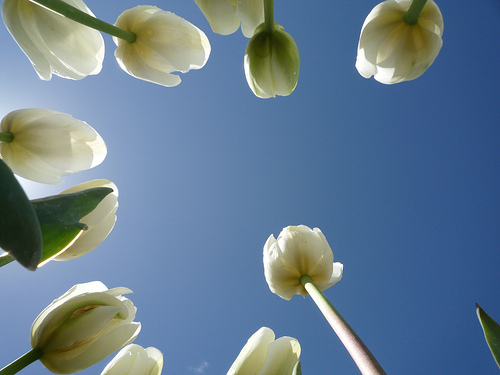

In [14]:
PIL.Image.open(str(tulips[1]))

## Carga y Creación de Datasets

cada subclase de imagenes está separada por una carpeta. Gracias a esto podemos utilizar la función `tf.keras.utils.image_dataset_from_directory`, que inmediatamente reconoce las diferentes etiquetas, genera pares `(imagen, etiqueta)` y crea datasets tipo `tf.Dataset`. Pero, vamos a crear este tipo de dato desde cero, para tener mayor control de cómo trabajamos con estos.

Iniciamos obteniendo los directorios de todas las imagenes descargadas.

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
# aleatorizamos el orden de estos directorios
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

Recuperemos algunos de estos directorios

In [20]:
for f in list_ds.take(5):
  print(f.numpy())

b'/mnt/storage/Datasets/flower_photos/roses/12450781274_eb78723921.jpg'
b'/mnt/storage/Datasets/flower_photos/daisy/18711159980_11d3bd5042.jpg'
b'/mnt/storage/Datasets/flower_photos/dandelion/20165867412_fc45d31698_m.jpg'
b'/mnt/storage/Datasets/flower_photos/sunflowers/417251603_69f0ee57a9_m.jpg'
b'/mnt/storage/Datasets/flower_photos/sunflowers/40410963_3ac280f23a_n.jpg'


Debido a la estructura de arbol de estos directorios, podemos extraer las etiquetas de los nombres de las carpetas

In [21]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Ahora podemos separar la lista de directorios en aquellos que serán usados en el dataset de entrenamiento y en el de validación

In [22]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Haremos ahora unas cuantas funciones que nos ayuden a generar los pares ordenados `(imagen, etiqueta)`.

Definamos algunas dimensiones

In [26]:
batch_size = 32
img_height = 180
img_width = 180

Hacemos una función para obtener la etiqueta y la codificarla

In [25]:
def get_label(file_path):
  # cortamos los directorios en sus componentes
  parts = tf.strings.split(file_path, os.path.sep)
  # el penultimo componente será la etiqueta
  one_hot = parts[-2] == class_names
  # codificamos esta clase en un número entero
  return tf.argmax(one_hot)

Ahora una función para "convertir" la dirección de la imagen en un tensor

In [27]:
def decode_img(img):
  # convertimos el string comprimido en un tensor 3D
  img = tf.io.decode_jpeg(img, channels=3)
  # Cambiamos el tamaño de la imagen a la esperada
  return tf.image.resize(img, [img_height, img_width])

Unimos las funciones anteriores para tener un procesamiento completo

In [28]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Aplicamos esta función sobre el dataset usando `Dataset.map`

In [30]:
AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# num_parallel_calls permite el procesamiento en paralelo

Veamos un ejemplo del resultado

In [32]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


### (Opcional) Mejorando el rendimiento

Podemos aplicar ciertas funciones especiales de la API `tf.data` para que nuestro dataset tenga ciertas mejoras. Las que se usarán ahora serán:

- mejora en la aleatorización
- generación de lotes
- tener velocidad en la obtención de los lotes
- Evitar cuellos de botella

Estas mejoras solo se recomiendan si su equipo lo permite.

In [33]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Visualicemos nuestro dataset

2022-09-09 19:06:35.265101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


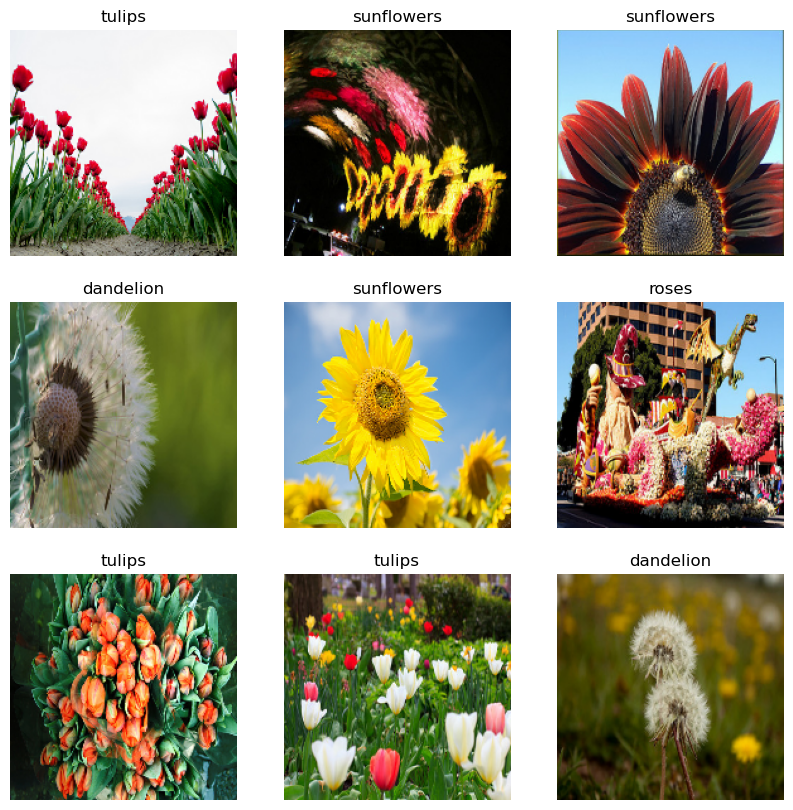

In [36]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Creación y entrenamiento del modelo

Entrenaremos un modelo básico de clasificación.

este contará con tres bloques convolucionales con una capa Max Pooling en cada uno de estos. Al final habrá una capa completamente conectada

In [47]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Usamos el optimizador "Adam" y la función de perdida `SparseCategoricalCrossentropy`

In [48]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Entrenamos el modelo

In [49]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 1s 10ms/step - loss: 1.2810 - accuracy: 0.4431 - val_loss: 1.1392 - val_accuracy: 0.5327
Epoch 2/10
92/92 [==============================] - 1s 10ms/step - loss: 0.9904 - accuracy: 0.6025 - val_loss: 1.0109 - val_accuracy: 0.5831
Epoch 3/10
92/92 [==============================] - 1s 11ms/step - loss: 0.7776 - accuracy: 0.7095 - val_loss: 0.9821 - val_accuracy: 0.5940
Epoch 4/10
92/92 [==============================] - 1s 10ms/step - loss: 0.6010 - accuracy: 0.7807 - val_loss: 1.1723 - val_accuracy: 0.5790
Epoch 5/10
92/92 [==============================] - 1s 10ms/step - loss: 0.3931 - accuracy: 0.8624 - val_loss: 1.2074 - val_accuracy: 0.6090
Epoch 6/10
92/92 [==============================] - 1s 10ms/step - loss: 0.2105 - accuracy: 0.9295 - val_loss: 1.4216 - val_accuracy: 0.6144
Epoch 7/10
92/92 [==============================] - 1s 11ms/step - loss: 0.1525 - accuracy: 0.9510 - val_loss: 1.6363 - val_accuracy: 0.5668
Epoch 8/10
92

Visualizamos ahora los resultados del entrenamiento

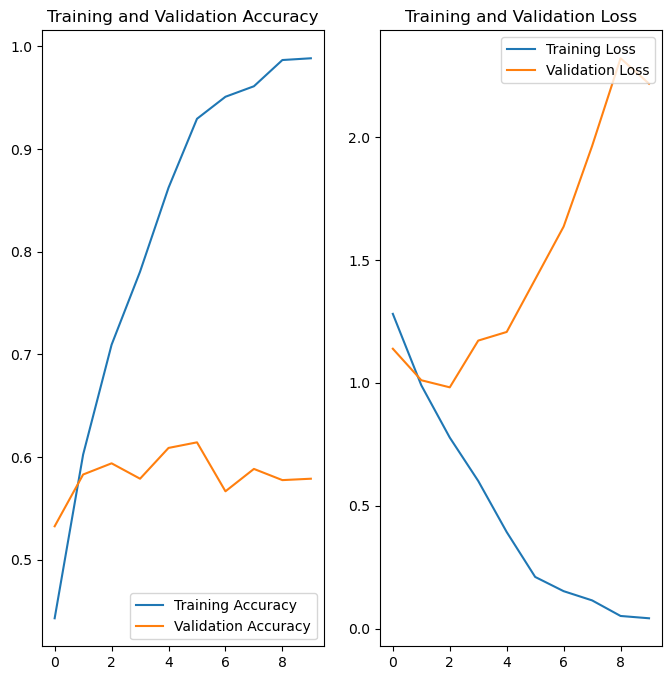

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Los resultados no son prometedores. Vemos una diferencia en la precisión de los datos de entrenamiento y validación. Teniendo una baja capacidad en el segundo dataset.

Esto solo puede significar una cosa.....*

## OVERFITTING

El modelo creado está teniendo serios problemas generalizando. Razón por la cual está teniendo tan buenos resultados en el entrenamiento, y tan mediocres en la validación.

¿Cuáles son las razones de este terrible acontecimiento? Pueden ser problemas tanto en el dataset, como en el diseño del modelo. Vamos a proponer una solución a cada una de estas

### Incremento artificial del dataset

Nuestra base de datos es pequeña, razón por la que necesitamos hacerla más grande. Pero, ¿qué tal si no tenemos acceso a más fotos? Podemos hacer transformaciones a los datos actuales. En este caso específico haremos rotaciones aleatorias a los datos.

Una forma interesante de hacer esto es creando una capa de la red cuyo trabajo sea el de generar esta rotación. Una ventaja de esto es que el proceso se correrá en la GPU.

In [52]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Veamos qué sucede al aplicar esta capa a una imagen

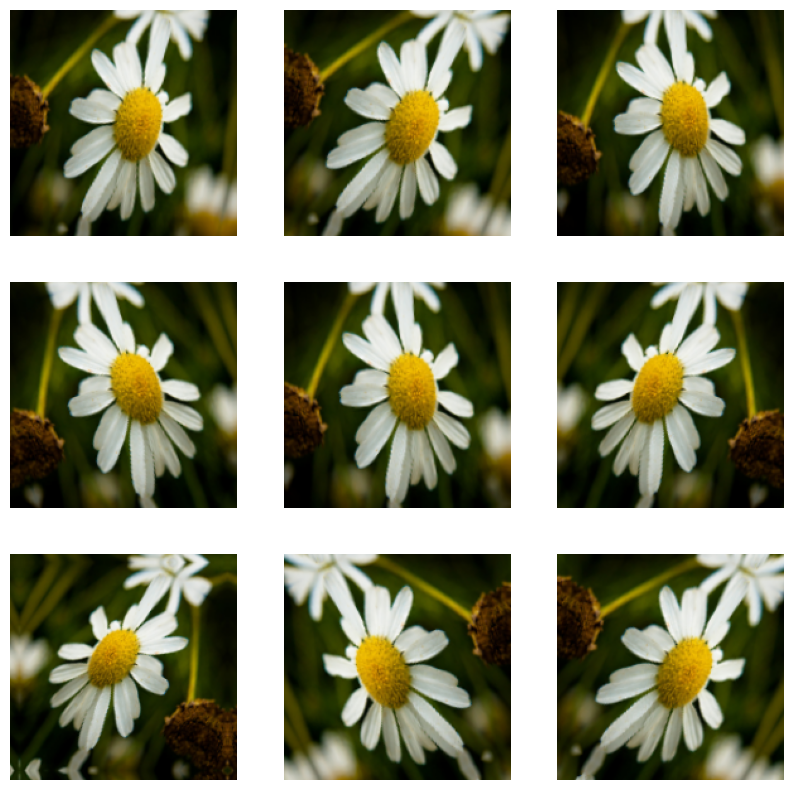

In [56]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

Es una buena costumbre agregar capas de "Dropout" en el modelo. Esta hará la activación de algunas unidades en un valor nulo. Esto regula el modelo y hace mitiga el overfit.

Definimos nuestro nuevo modelo con nuestras nuevas herramientas

In [57]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [60]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 20ms/step - loss: 1.2692 - accuracy: 0.4601 - val_loss: 1.1198 - val_accuracy: 0.5381
Epoch 2/15
92/92 [==============================] - 1s 15ms/step - loss: 1.0111 - accuracy: 0.6056 - val_loss: 1.0223 - val_accuracy: 0.5872
Epoch 3/15
92/92 [==============================] - 1s 15ms/step - loss: 0.9091 - accuracy: 0.6437 - val_loss: 0.9523 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 1s 15ms/step - loss: 0.8280 - accuracy: 0.6751 - val_loss: 0.8627 - val_accuracy: 0.6744
Epoch 5/15
92/92 [==============================] - 1s 15ms/step - loss: 0.7701 - accuracy: 0.7037 - val_loss: 0.8269 - val_accuracy: 0.6676
Epoch 6/15
92/92 [==============================] - 1s 15ms/step - loss: 0.7490 - accuracy: 0.7122 - val_loss: 0.8059 - val_accuracy: 0.6757
Epoch 7/15
92/92 [==============================] - 1s 15ms/step - loss: 0.7053 - accuracy: 0.7289 - val_loss: 0.8281 - val_accuracy: 0.6812
Epoch 8/15
92

Volvemos a revisar la perdida y la precisión

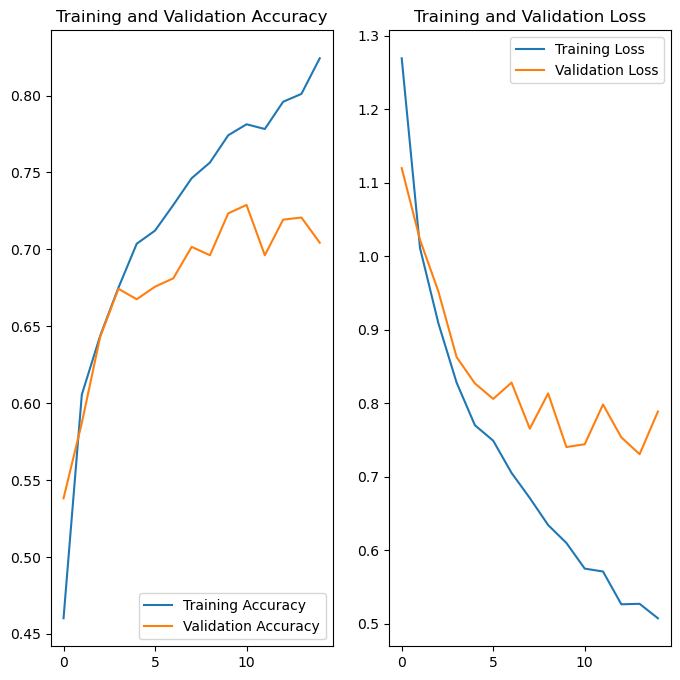

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()